<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_02_4_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 2: Neural Networks with Tensorflow and Keras**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 2 Material

* Part 2.1: Introduction to Neural Networks with Tensorflow and Keras
* Part 2.2: Encoding Feature Vectors
* Part 2.3: Controlling Overfitting
* **Part 2.4: Saving and Loading a Keras Neural Network**

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [ ]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    COLAB = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.

![__](https://biologicslab.co/BIO1173/images/class_01/class_01_6_image01A.png)

If your GMAIL address does not appear your lesson will **not** be graded.

### Create Custom Functions

Run the cell below to create the functions needed for this lesson.

In [ ]:
# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Simple function to change column name in a dataframe
def rename_col_by_index(dataframe, index_mapping):
    dataframe.columns = [index_mapping.get(i, col) for i, col in enumerate(dataframe.columns)]
    return dataframe

# **Saving and Loading a Keras Neural Network**

Complex neural networks will take a _long_ time to fit/train.  It is helpful to be able to save a trained neural network so that you can reload it and using it again.  Again, a reloaded neural network will **not** require retraining.  

Keras provides the following two formats for saving neural networks:

* **JSON** - Stores the neural network structure (no weights) in the [JSON file format](https://en.wikipedia.org/wiki/JSON).
* **Keras** - Stores the complete neural network (with weights) in the native Keras format.

Usually, you will want to save in native Keras format.

### Example 1A: Build, Compile and Train Classification Neural Network

The code in `Example 1` builds, compiles and trains a neural network called `or_model` that can classify the `Quality` of an orange based on its physical and chemical characteristics.

The code in the cell below reads the Orange Quality dataset from the course HTTP server and creates a DataFrame called `or_df` (i.e. "orange" DataFrame).

In order to create a feature vector, the 3 non-numeric columns in the dataset: `Color`, `Variety` and `Blemished` must be pre-processed. Mapping strings to integers is used to take care of the column `Color` while one-hot encoding is used to take care the column `Variety`. To take care of the column `Blemish`, it will simply be excluded (dropped) from the column list when generating the X-values.

The following code chunk identifies which columns in `or_df` are numeric:
```text
numeric_cols = or_df.select_dtypes(include=['int64', 'float64']).columns
```
Once we have identified the numeric columns, we can use the following code chunk to normalizes all numeric values to their Z-scores:
```text
or_df[numeric_cols] = or_df[numeric_cols].apply(zscore)
```

Since we are building a classification neural network, we will need to one-hot encode the column `Quality` which contains the `Y-values`. It should be noted that this column is already numeric, so we are **not** using one-hot encoding to replace string values with integer. Rather, one-hot Encoding the `Y-values` is necessary to give them the **correct format** for the neural network.

Again, because we want `or_model` to act as a _classifier_, not a "regressor", we will use the `softmax` activation function in the output layer.

Finally, we will compile the model using `categorical_crossentropy` as the loss function instead of using `mean_squared_error`.   


In [ ]:
# Example 1A: Build, Compile and Train Classification Model

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import time
import numpy as np
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
or_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/orange_quality.csv",
    na_values=['NA', '?'])


# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------

# Map str to int
mapping = {'Orange':0,'Deep Orange':1,
           'Light Orange':2,'Orange-Red':3,
           'Yellow-Orange':4}
or_df['Color'] = or_df['Color'].map(mapping)

# Standardise all numeric column with z‑score
numeric_cols = or_df.select_dtypes(include=['int64', 'float64']).columns
or_df[numeric_cols] = or_df[numeric_cols].apply(zscore)


# Generate X-values
or_X = or_df[['Size (cm)', 'Weight (g)', 'Brix (Sweetness)', 'pH (Acidity)',
       'Softness (1-5)', 'HarvestTime (days)', 'Ripeness (1-5)',
        'Color']].values
or_X = np.asarray(or_X).astype('float32')

# Generate Y-values
dummies = pd.get_dummies(or_df['Quality (1-5)'], dtype=int) # Classification
or_Y = dummies.values
or_Y = np.asarray(or_Y).astype('float32')

# ------------------------------------------------------------
# 6️⃣  Build & compile model
# ------------------------------------------------------------

# Build model
or_model = Sequential([
    Input(shape=(or_X.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(or_Y.shape[1], activation='softmax')
])

or_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ------------------------------------------------------------
# 7️⃣  Callbacks (monitor accuracy)
# ------------------------------------------------------------
checkpoint_path = "or_best_classification_model.keras"
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=PATIENCE,
        restore_best_weights=True,
        mode="max"          # <– add this line
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
]

# ------------------------------------------------------------
# 8️⃣  Train model
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()
or_history = or_model.fit(
    or_X, or_Y,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=VERBOSE,
)

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished.")
print(f"Best val accuracy: {np.max(or_history.history['val_accuracy']):.4f}")

# --- NEW: print the *last* epoch that was executed -------------
if or_history.epoch:                       # safety guard – should always be true
    last_epoch = or_history.epoch[-1] + 1  # +1 → human‑friendly (1‑based) count
    print(f"Training ran through epoch #{last_epoch} (total {len(or_history.epoch)} epochs).")
else:
    print("No epochs were run.")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

------Training Starting for 100 epochs --------------

Training finished.
Best val accuracy: 0.4286
Training ran through epoch #25 (total 25 epochs).
Elapsed time: 0:00:05.14


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_4_image01B.png)

Our `or_model` neural network doesn't appear to have done a very good job since the best validation accuracy (`val accuracy`) is only about 40-45%. It should also be noted that in this particular run, `EarlyStopping` terminated training at the 25th epoch.

### Example 1B: Visualize Training

The code in the cell below generates two side-by-side plots, **`Accuracy`**

Best validation accuracy: 0.4286
Best validation loss: 1.7553


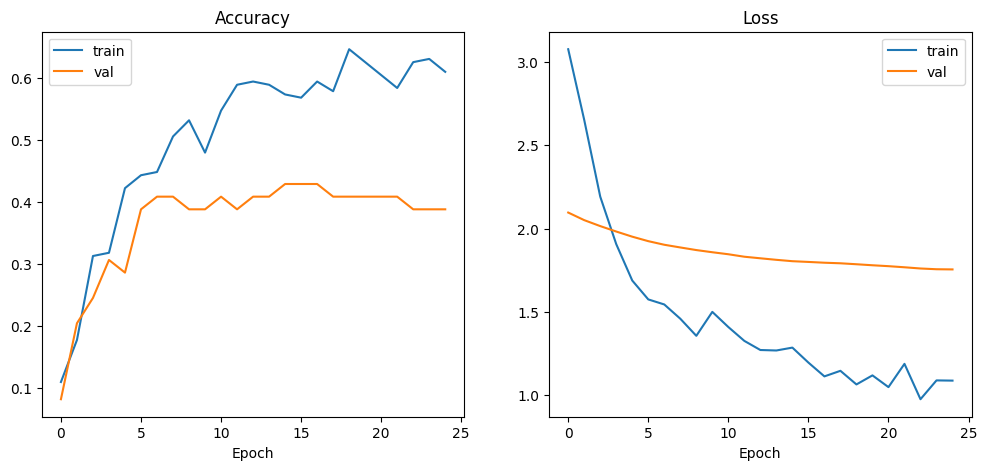

In [44]:
import numpy as np

# Show the best validation accuracy
best_val_acc = np.max(or_history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Show the best validation loss
best_val_loss = np.min(or_history.history['val_loss'])
print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(or_history.history['accuracy'], label='train')
plt.plot(or_history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(or_history.history['loss'], label='train')
plt.plot(or_history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_4_image02B.png)

### **Exercise 1: Build and Train a Classification Neural Network**

In the cell below build and train a new classification neural network called `ap_model`.

Start by reading the dataset and creating a DataFrame called `ap_df` ("apple" DataFrame) using this code chunk:
~~~text
ap_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/apple_quality.csv",
    na_values=['NA', '?'])
~~~
The goal of your neural network model `ap_model` will be to classify the apples in the Apple Quality dataset using the values in the following columns: 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Acidity' and 'Ripeness'. Since all of these columns are numeric, there is no need pre-process any of these columns. Moreover, the numerical values all have a similar magnitude so you don't need to standardize any column to their z-scores. Nor do you need to split the data into Training/Validation sets or suffle the data. When you generate your X-values, you should called them `ap_X`.

Since you are building a classification neural network, you will need to One-Hot Encode the column containing the Y-values, `Quality`. This column is non-numeric, so by One-Hot Encoding it, you will accomplish two things: (1) replace string values with integers and (2) give the Y-values the correct format for the neural network. When you generate your Y-values, you should called them `ap_Y`.

Again, because you want your `ap_model` to act as a _classifier_, use the `softmax` activation function in the output layer. You should also compile your model using `categorical_crossentropy` as the loss function.

Finally, train (fit) your model on your X-values (`ap_X`) and your Y-values (`ap_Y`) for 100 epochs.  

In [ ]:
# -------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------
import pandas as pd
import time
import numpy as np
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint

# -------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------
EPOCHS   = 100
PATIENCE = 10
VERBOSE  = 2           # 2 = progress bars

# -------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------
ap_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/apple_quality.csv",
    na_values=['NA', '?']
)

# -------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------
# 5.1 Map text to numeric (if needed – the dataset already uses
# numeric quality, so this step is optional)
# mapping = {'Size':..., 'Weight':..., ...}

# 5.2 Standardise numeric predictors (optional but often helps)
# ap_df[['Size','Weight','Sweetness','Crunchiness',
#        'Juiciness','Acidity','Ripeness']] = \
#     ap_df[['Size','Weight','Sweetness','Crunchiness',
#            'Juiciness','Acidity','Ripeness']].apply(zscore)

# 5.3 Generate X‑values
ap_X = ap_df[['Size', 'Weight', 'Sweetness', 'Crunchiness',
              'Juiciness', 'Acidity', 'Ripeness']].values
ap_X = np.asarray(ap_X).astype('float32')

# 5.4 Generate Y‑values (one‑hot for classification)
dummies = pd.get_dummies(ap_df['Quality'], dtype=int)
ap_Y = dummies.values
ap_Y = np.asarray(ap_Y).astype('float32')

# -------------------------------------------------------------
# 6️⃣  Build & compile model
# -------------------------------------------------------------
ap_model = Sequential()
ap_model.add(Input(shape=(ap_X.shape[1],)))         # Input layer
ap_model.add(Dense(50, activation='relu'))          # Hidden 1
ap_model.add(Dense(25, activation='relu'))          # Hidden 2
ap_model.add(Dense(ap_Y.shape[1], activation='softmax'))  # Output

ap_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# -------------------------------------------------------------
# 7️⃣  Callbacks (monitor accuracy)
# -------------------------------------------------------------
checkpoint_path = "ap_best_classification_model.keras"
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=PATIENCE,
        restore_best_weights=True,
        mode="max"
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
]

# -------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()
ap_history = ap_model.fit(
    ap_X, ap_Y,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=VERBOSE
)

# -------------------------------------------------------------
# 9️⃣  Inspect training
# -------------------------------------------------------------
print("\nTraining finished")
print(f"Best val accuracy: {np.max(ap_history.history['val_accuracy']):.4f}")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


------Training Starting for 100 epochs --------------
Epoch 1/100
100/100 - 2s - 22ms/step - accuracy: 0.7250 - loss: 0.5549 - val_accuracy: 0.8175 - val_loss: 0.4220
Epoch 2/100
100/100 - 0s - 5ms/step - accuracy: 0.8369 - loss: 0.3735 - val_accuracy: 0.8537 - val_loss: 0.3421
Epoch 3/100
100/100 - 1s - 6ms/step - accuracy: 0.8647 - loss: 0.3160 - val_accuracy: 0.8650 - val_loss: 0.3076
Epoch 4/100
100/100 - 0s - 4ms/step - accuracy: 0.8769 - loss: 0.2882 - val_accuracy: 0.8838 - val_loss: 0.2921
Epoch 5/100
100/100 - 0s - 2ms/step - accuracy: 0.8872 - loss: 0.2735 - val_accuracy: 0.8838 - val_loss: 0.2846
Epoch 6/100
100/100 - 0s - 4ms/step - accuracy: 0.8881 - loss: 0.2572 - val_accuracy: 0.8925 - val_loss: 0.2717
Epoch 7/100
100/100 - 1s - 5ms/step - accuracy: 0.8956 - loss: 0.2481 - val_accuracy: 0.8913 - val_loss: 0.2687
Epoch 8/100
100/100 - 0s - 3ms/step - accuracy: 0.9006 - loss: 0.2399 - val_accuracy: 0.8900 - val_loss: 0.2658
Epoch 9/100
100/100 - 0s - 3ms/step - accuracy: 0

In [ ]:
# Insert your code for Exercise 1A here

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import time
import numpy as np
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2     # 2 means output during training

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ap_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/apple_quality.csv",
    na_values=['NA', '?'])


# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------

# Map str to int

# 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Acidity' and 'Ripeness'.

# Generate X-values
ap_X = ap_df[['Size', 'Weight', 'Sweetness', 'Crunchiness',
       'Juiciness', 'Acidity', 'Ripeness']].values
ap_X = np.asarray(ap_X).astype('float32')

# Generate Y-values
dummies = pd.get_dummies(ap_df['Quality'], dtype=int) # Classification
ap_Y = dummies.values
ap_Y = np.asarray(ap_Y).astype('float32')

# ------------------------------------------------------------
# 6️⃣  Build & compile model
# ------------------------------------------------------------

# Build model
ap_model = Sequential()
ap_model.add(Input(shape=(ap_X.shape[1],)))  # Input
ap_model.add(Dense(50, activation='relu')) # Hidden 1
ap_model.add(Dense(25, activation='relu')) # Hidden 2
ap_model.add(Dense(ap_Y.shape[1],activation='softmax')) # Output

# Compile model
ap_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ------------------------------------------------------------
# 7️⃣  Callbacks (monitor accuracy)
# ------------------------------------------------------------
checkpoint_path = "or_best_classification_model.keras"
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=PATIENCE,
        restore_best_weights=True,
        mode="max"          # <– add this line
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
]

# ------------------------------------------------------------
# 8️⃣  Train model
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()
ap_history = ap_model.fit(
    ap_X, ap_Y,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=VERBOSE,
)

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print(f"Best val accuracy: {np.max(or_history.history['val_accuracy']):.4f}")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

------Training Starting for 100 epochs --------------
Epoch 1/100
100/100 - 2s - 23ms/step - accuracy: 0.7409 - loss: 0.5207 - val_accuracy: 0.8300 - val_loss: 0.4030
Epoch 2/100
100/100 - 1s - 10ms/step - accuracy: 0.8431 - loss: 0.3528 - val_accuracy: 0.8662 - val_loss: 0.3335
Epoch 3/100
100/100 - 0s - 3ms/step - accuracy: 0.8625 - loss: 0.3095 - val_accuracy: 0.8763 - val_loss: 0.3086
Epoch 4/100
100/100 - 0s - 3ms/step - accuracy: 0.8741 - loss: 0.2890 - val_accuracy: 0.8800 - val_loss: 0.2996
Epoch 5/100
100/100 - 0s - 3ms/step - accuracy: 0.8834 - loss: 0.2748 - val_accuracy: 0.8850 - val_loss: 0.2903
Epoch 6/100
100/100 - 0s - 3ms/step - accuracy: 0.8888 - loss: 0.2667 - val_accuracy: 0.8838 - val_loss: 0.2793
Epoch 7/100
100/100 - 0s - 3ms/step - accuracy: 0.8928 - loss: 0.2553 - val_accuracy: 0.8888 - val_loss: 0.2818
Epoch 8/100
100/100 - 0s - 3ms/step - accuracy: 0.8975 - loss: 0.2513 - val_accuracy: 0.8900 - val_loss: 0.2671
Epoch 9/100
100/100 - 0s - 3ms/step - accuracy: 

### Example 1B: Visualize Training

The code in the cell below generates two side-by-side plots, **`Accuracy`**

Best validation accuracy: 0.3673
Best validation loss: 1.7409


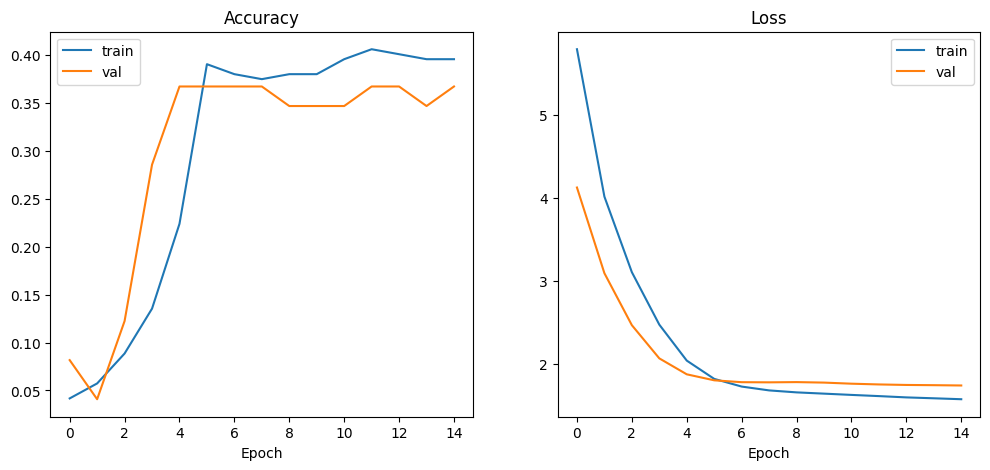

In [ ]:
import numpy as np

# Show the best validation accuracy
best_val_acc = np.max(or_histor_Y.histor_Y['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Show the best validation loss
best_val_loss = np.min(or_histor_Y.histor_Y['val_loss'])
print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training histor_Y
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(or_histor_Y.histor_Y['accuracy'], label='train')
plt.plot(or_histor_Y.histor_Y['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(or_histor_Y.histor_Y['loss'], label='train')
plt.plot(or_histor_Y.histor_Y['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
# Insert your code for Exercise 1 here

# Example 1: Build and Train Classification Model


Training your model will take longer since the Apple Quality dataset contains 4,000 items instead of only 241 in the Orange Quality dataset.

If your code was correct your should see something similiar to the following output:
~~~text
Epoch 1/100
125/125 - 1s - loss: 0.4866 - 746ms/epoch - 6ms/step
Epoch 2/100
125/125 - 0s - loss: 0.3555 - 440ms/epoch - 4ms/step
Epoch 3/100
125/125 - 0s - loss: 0.3111 - 444ms/epoch - 4ms/step
Epoch 4/100
125/125 - 0s - loss: 0.2861 - 435ms/epoch - 3ms/step
Epoch 5/100
125/125 - 0s - loss: 0.2686 - 497ms/epoch - 4ms/step

............................................

Epoch 95/100
125/125 - 0s - loss: 0.0764 - 429ms/epoch - 3ms/step
Epoch 96/100
125/125 - 0s - loss: 0.0734 - 429ms/epoch - 3ms/step
Epoch 97/100
125/125 - 0s - loss: 0.0741 - 447ms/epoch - 4ms/step
Epoch 98/100
125/125 - 1s - loss: 0.0732 - 507ms/epoch - 4ms/step
Epoch 99/100
125/125 - 0s - loss: 0.0723 - 418ms/epoch - 3ms/step
Epoch 100/100
125/125 - 0s - loss: 0.0719 - 416ms/epoch - 3ms/s
~~~

Notice that in this example, the loss went from `0.4866` after the 1st epoch down to `0.0719` after the 100th epoch.

### Example 2: Determine the Model's RSME and Accuracy

The overall objective of this assignment is to convince you that can save a _trained_ neural network to a file, and then later, recreate the neural network from the file, **_without changing the model's accuracy_**.

#### Why is this important?

As you already know, it can take significant time and processing power to train even relatively small neural networks that we created so far in this course. Neural networks that are used commercially (think "Siri" or "Alexa" or ChatGPT) are many times larger and require enormous resources as well as weeks (or months) to train. Obviously, if you had to train a neural network every time you wanted to use it, it won't be very practical and there would be little interest in "AI". However, once the neural network has been trained, you can save it to a file, and then re-use it over and over again, without any loss in the neural network's ability to solve problems (i.e. loss in accuracy).      

The code in the cell below calculates ability of the `or_model` neural network to predict an orange's quality (Y-value) based on its physical and chemical characteristics (X-values). Two measures of predictive ability are computed, the **_Root Mean Square Error (RMSE)_** and **_Accuracy_**. The code stores the RSME value in the variable `orScore` and the Accuracy value in the variable `orCorrect` and then prints out thes values.


In [ ]:
# Example 2: Determine the model's RMSE and Accuracy

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Measure RMSE error.
orPred = or_model.predict(or_X)
orScore = np.sqrt(metrics.mean_squared_error(orPred,or_Y))
print(f"Before save score (RMSE): {orScore}")

# Measure the accuracy
orPredict_classes = np.argmax(orPred,axis=1)
orExpected_classes = np.argmax(or_Y,axis=1)
orCorrect = accuracy_score(orExpected_classes,orPredict_classes)
print(f"Before save Accuracy: {orCorrect}")

If your code is correct you should see something similar to the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image01A.png)

The `or_model` isn't doing that great (Accuracy ~50% accurate). A model with 50% accuracy is about a accurate as just flipping a coin.

However, as mentioned above, the number of items (oranges) in this dataset is relatively small (_n_=241). As you can see, this is really too few samples for training a neural network and then to expect a high level of accuracy.

### **Exercise 2: Determine the Model's RSME and Accuracy**

In the cell below, determine the RSME and Accuracy of your `ap_model`. Store the RSME value in a variable called `apScore` and the Accuracy value in a variable called `apCorrect`. Print out these values as shown in Example 2 above.

In [ ]:
# Insert your code for Exercise 2 here


If your code is correct you should see something similar to the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image02A.png)

According to the output above, your `ap_model` is better than 70% accurate when it comes to predicting apple quality. Apparently, it's a little easier to predict an apple's `Quality` with a classification neural network than to predict orange quality.

### Example 3: Save the Model

The code in the cell below saves the _trained_ neural network `or_model` as a file in two different file formats: `JSON` and `keras`.

Each file in the current working director_Y (`save_path = "."`). The filename of the JSON file is `or_model.json` while the filename of the `keras` file is `or_model.keras`.

In [ ]:
# Example 3: Save the model

from keras.models import save_model
import os

# Save path is the current director_Y
save_path = "."

# Save neural network structure to JSON (no weights)
or_model_json = or_model.to_json()
with open(os.path.join(save_path,"or_model.json"), "w") as json_file:
    json_file.write(or_model_json)

# Save the model in the native Keras format
or_model.save('or_model.keras')

# Print out the files in current director_Y
files = os.listdir()
print(files)

If your code is correct you should see the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image03A.png)

After running the code cell above, there should now be two new files in your `Class_02_4` folder called `or_model.jason` and `or_model.keras`.

### **Exercise 3: Save the Model**

In the code cell below save your _trained_ neural network `ap_model` as a JSON file with the filename, `ap_model.json`, and as a native Keras file with the filenmane `ap_model.keras`. Save both files to your current working director_Y (`save_path = "."`).

In [ ]:
# Insert your code for Exercise 3 here


If your code is correct you should see something similar to the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image04A.png)

You should now see the two more files with your neural network.

The advantage of the JSON format is that it can be visually inspected -- just click on the file name in the file browser panel. The JSON file perserves the model's _architecture_ which you can see by looking at the JSON file, but if you want to use it, you will need to train all over again.

On the other hand, you can't view the contents of the HDF5 file, since it is not UTF-8 encoded (it's formated). Neverthelss, you should always save your model in the HDF5 format since this **_preserves architecture and the values of the weights_** of the model's connections. By preserving these values you don't have to waste time retraining the model again.

### Example 4: Create New Model from Saved Model

Once a trained model has been saved in the HDF5 format, it is a simple matter to read the file to make an exact copy of the model using the Keras function `load_model()` as shown in the cell below. In Example 4 we have given the re-loaded neural network the name `or2Model` to differentiate it from the one that we built previously.  

In [ ]:
# Example 4: Create new model from saved model

from keras.models import load_model

# Look in current folder
save_path = "."

# Create model2 from the saved model
or2Model = load_model(os.path.join(save_path,"or_model.keras"))

# Print out model summary
or2Model.summary()

If your code is correct you should see the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image05A.png)

### **Exercise 4: Create New Model from Saved Model**

In the cell below create a new neural network called `ap2Model` from the file `ap_model.keras` in your current director_Y. Print out a summary of your new `ap2Model`.

In [ ]:
# Insert your code for Exercise 4 here


If your code is correct you should see the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image06A.png)

### Example 5: Compare the Predictive Accuracy of the Old and New Models

The code in the cell below computes the RMSE error and the Accuracy of our new model `or2Model` and compares these values with the original `or_model`. We are trying to address the question whether re-loaded model has the same accuracy as the original model?

In [ ]:
# Example 5: Determine new model's RMSE and Accuracy

import numpy as np
import math

# Measure RMSE error.
or2Pred = or2Model.predict(or_X)
or2Score = np.sqrt(metrics.mean_squared_error(or2Pred,or_Y))
print(f"Before save score (RMSE): {orScore}")
print(f"After save score (RMSE) : {or2Score}")

# Measure the accuracy
or2Predict_classes = np.argmax(or2Pred,axis=1)
or2Expected_classes = np.argmax(or_Y,axis=1)
or2Correct = accuracy_score(or2Expected_classes,or2Predict_classes)
print(f"Before save Accuracy: {orCorrect}")
print(f"After save Accuracy : {or2Correct}")

If your code is correct you should see something similar to the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image07A.png)

As you can see, there is **_no difference_** in the accuracy of the saved model compared to the original one.

### **_...Train Once...Use Anywhere!_**

Big generative models like `ChatGTP` can take days or even months to train. But once they are trained and saved, they can process new data very fast.

### **Exercise 5: Compare the Predictive Accuracy of the Old and New Models**

In the cell below write the code to compute the RMSE and Accuracy values for your `ap2Model` and print out these values along with the values for your original `ap_model`.

In [ ]:
# Insert your code for Exercise 5 here


If your code is correct you should see something similar to the following output:

![__](https://biologicslab.co/BIO1173/images/class_02/class_02_4_image08A.png)

As you can see, again, there is **_no difference_** in the accuracy of the model saved in the `keras` format compared to the original one.


## **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_02_4.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.

## **Lizard Tail**


## **Stable Diffusion**

![___](https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Astronaut_Riding_a_Horse_%28SD3.5%29.webp/1024px-Astronaut_Riding_a_Horse_%28SD3.5%29.webp.png)

>*An image generated with Stable Diffusion 3.5 based on the text prompt*

**Stable Diffusion** is a deep learning, text-to-image model released in 2022 based on diffusion techniques. The generative artificial intelligence technology is the premier product of `Stability AI` and is considered to be a part of the ongoing artificial intelligence boom.

It is primarily used to generate detailed images conditioned on text descriptions, though it can also be applied to other tasks such as inpainting, outpainting, and generating image-to-image translations guided by a text prompt.[3] Its development involved researchers from the CompVis Group at Ludwig Maximilian University of Munich and Runway with a computational donation from Stability and training data from non-profit organizations.

**Stable Diffusion** is a latent diffusion model, a kind of deep generative artificial neural network. Its code and model weights have been released publicly, and it can run on most consumer hardware equipped with a modest GPU with at least 4 GB VRAM. This marked a departure from previous proprietary text-to-image models such as DALL-E and Midjourney which were accessible only via cloud services.

**Development**

Stable Diffusion originated from a project called Latent Diffusion, developed in Germany by researchers at Ludwig Maximilian University in Munich and Heidelberg University. Four of the original 5 authors (Robin Rombach, Andreas Blattmann, Patrick Esser and Dominik Lorenz) later joined Stability AI and released subsequent versions of Stable Diffusion.

The technical license for the model was released by the CompVis group at Ludwig Maximilian University of Munich. Development was led by Patrick Esser of Runway and Robin Rombach of CompVis, who were among the researchers who had earlier invented the latent diffusion model architecture used by Stable Diffusion. Stability AI also credited EleutherAI and LAION (a German nonprofit which assembled the dataset on which Stable Diffusion was trained) as supporters of the project.

**Technology**

The denoising process used by Stable Diffusion. The model generates images by iteratively denoising random noise until a configured number of steps have been reached, guided by the CLIP text encoder pretrained on concepts along with the attention mechanism, resulting in the desired image depicting a representation of the trained concept.

**Architecture**

Diffusion models, introduced in 2015, are trained with the objective of removing successive applications of Gaussian noise on training images, which can be thought of as a sequence of denoising autoencoders. The name diffusion is from the thermodynamic diffusion, since they were first developed with inspiration from thermodynamics.

Models in Stable Diffusion series before SD 3 all used a variant of diffusion models, called latent diffusion model (LDM), developed in 2021 by the CompVis (Computer Vision & Learning) group at LMU Munich.

Stable Diffusion consists of 3 parts: the variational autoencoder (VAE), U-Net, and an optional text encoder. The VAE encoder compresses the image from pixel space to a smaller dimensional latent space, capturing a more fundamental semantic meaning of the image. Gaussian noise is iteratively applied to the compressed latent representation during forward diffusion. The U-Net block, composed of a ResNet backbone, denoises the output from forward diffusion backwards to obtain a latent representation. Finally, the VAE decoder generates the final image by converting the representation back into pixel space.

The denoising step can be flexibly conditioned on a string of text, an image, or another modality. The encoded conditioning data is exposed to denoising U-Nets via a cross-attention mechanism. For conditioning on text, the fixed, pretrained CLIP ViT-L/14 text encoder is used to transform text prompts to an embedding space. Researchers point to increased computational efficiency for training and generation as an advantage of LDMs.

With 860 million parameters in the U-Net and 123 million in the text encoder, Stable Diffusion is considered relatively lightweight by 2022 standards, and unlike other diffusion models, it can run on consumer GPUs, and even CPU-only if using the OpenVINO version of Stable Diffusion.

**SD XL**
The XL version uses the same LDM architecture as previous versions, except larger: larger UNet backbone, larger cross-attention context, two text encoders instead of one, and trained on multiple aspect ratios (not just the square aspect ratio like previous versions).

The SD XL Refiner, released at the same time, has the same architecture as SD XL, but it was trained for adding fine details to preexisting images via text-conditional img2img.

**SD 3.0**

Main article: Diffusion model § Rectified flow
The 3.0 version completely changes the backbone. Not a UNet, but a Rectified Flow Transformer, which implements the rectified flow method with a Transformer.

The Transformer architecture used for SD 3.0 has three "tracks", for original text encoding, transformed text encoding, and image encoding (in latent space). The transformed text encoding and image encoding are mixed during each transformer block.

The architecture is named "multimodal diffusion transformer (MMDiT), where the "multimodal" means that it mixes text and image encodings inside its operations. This differs from previous versions of DiT, where the text encoding affects the image encoding, but not vice versa.

**Training data**

Stable Diffusion was trained on pairs of images and captions taken from LAION-5B, a publicly available dataset derived from Common Crawl data scraped from the web, where 5 billion image-text pairs were classified based on language and filtered into separate datasets by resolution, a predicted likelihood of containing a watermark, and predicted "aesthetic" score (e.g. subjective visual quality). The dataset was created by LAION, a German non-profit which receives funding from Stability AI. The Stable Diffusion model was trained on three subsets of LAION-5B: laion2B-en, laion-high-resolution, and laion-aesthetics v2 5+. A third-party analysis of the model's training data identified that out of a smaller subset of 12 million images taken from the original wider dataset used, approximately 47% of the sample size of images came from 100 different domains, with Pinterest taking up 8.5% of the subset, followed by websites such as WordPress, Blogspot, Flickr, DeviantArt and Wikimedia Commons. An investigation by Bayerischer Rundfunk showed that LAION's datasets, hosted on Hugging Face, contain large amounts of private and sensitive data.

**Training procedures**

The model was initially trained on the laion2B-en and laion-high-resolution subsets, with the last few rounds of training done on LAION-Aesthetics v2 5+, a subset of 600 million captioned images which the LAION-Aesthetics Predictor V2 predicted that humans would, on average, give a score of at least 5 out of 10 when asked to rate how much they liked them. The LAION-Aesthetics v2 5+ subset also excluded low-resolution images and images which LAION-5B-WatermarkDetection identified as carrying a watermark with greater than 80% probability. Final rounds of training additionally dropped 10% of text conditioning to improve Classifier-Free Diffusion Guidance.

The model was trained using 256 Nvidia A100 GPUs on Amazon Web Services for a total of 150,000 GPU-hours, at a cost of $600,000.

![__](https://upload.wikimedia.org/wikipedia/commons/f/f6/Stable_Diffusion_architecture.png)

>Diagram of the latent diffusion architecture used by Stable Diffusion


**Limitations**

Stable Diffusion has issues with degradation and inaccuracies in certain scenarios. Initial releases of the model were trained on a dataset that consists of 512×512 resolution images, meaning that the quality of generated images noticeably degrades when user specifications deviate from its "expected" 512×512 resolution; the version 2.0 update of the Stable Diffusion model later introduced the ability to natively generate images at 768×768 resolution. Another challenge is in generating human limbs due to poor data quality of limbs in the LAION database. The model is insufficiently trained to replicate human limbs and faces due to the lack of representative features in the database, and prompting the model to generate images of such type can confound the model. Stable Diffusion XL (SDXL) version 1.0, released in July 2023, introduced native 1024x1024 resolution and improved generation for limbs and text.

Accessibility for individual developers can also be a problem. In order to customize the model for new use cases that are not included in the dataset, such as generating anime characters ("waifu diffusion"), new data and further training are required. Fine-tuned adaptations of Stable Diffusion created through additional retraining have been used for a variety of different use-cases, from medical imaging to algorithmically generated music. However, this fine-tuning process is sensitive to the quality of new data; low resolution images or different resolutions from the original data can not only fail to learn the new task but degrade the overall performance of the model. Even when the model is additionally trained on high quality images, it is difficult for individuals to run models in consumer electronics. For example, the training process for waifu-diffusion requires a minimum 30 GB of VRAM, which exceeds the usual resource provided in such consumer GPUs as Nvidia's GeForce 30 series, which has only about 12 GB.

The creators of Stable Diffusion acknowledge the potential for algorithmic bias, as the model was primarily trained on images with English descriptions. As a result, generated images reinforce social biases and are from a western perspective, as the creators note that the model lacks data from other communities and cultures. The model gives more accurate results for prompts that are written in English in comparison to those written in other languages, with western or white cultures often being the default representation.

**End-user fine-tuning**

To address the limitations of the model's initial training, end-users may opt to implement additional training to fine-tune generation outputs to match more specific use-cases, a process also referred to as personalization. There are three methods in which user-accessible fine-tuning can be applied to a Stable Diffusion model checkpoint:

An "embedding" can be trained from a collection of user-provided images, and allows the model to generate visually similar images whenever the name of the embedding is used within a generation prompt.[44] Embeddings are based on the "textual inversion" concept developed by researchers from Tel Aviv University in 2022 with support from Nvidia, where vector representations for specific tokens used by the model's text encoder are linked to new pseudo-words. Embeddings can be used to reduce biases within the original model, or mimic visual styles.

A "hypernetwork" is a small pretrained neural network that is applied to various points within a larger neural network, and refers to the technique created by NovelAI developer Kurumuz in 2021, originally intended for text-generation transformer models. Hypernetworks steer results towards a particular direction, allowing Stable Diffusion-based models to imitate the art style of specific artists, even if the artist is not recognised by the original model; they process the image by finding key areas of importance such as hair and eyes, and then patch these areas in secondary latent space.
DreamBooth is a deep learning generation model developed by researchers from Google Research and Boston University in 2022 which can fine-tune the model to generate precise, personalised outputs that depict a specific subject, following training via a set of images which depict the subject.